In [5]:
import pandas as pd
df = pd.read_csv('afm/PM2C_443,446/test9_distance.csv',delimiter='\t' )
print(df.to_string()) 

       Δx [nm]    Δy [nm]     φ [deg]      R [nm]     Δz [pm]
0    59.668444  68.618710  -48.990913   90.933221  -43.612502
1    26.850800 -47.734755   60.642246   54.768351 -212.504625
2    29.834222 -50.718177   59.534455   58.842283   -7.082890
3    17.900533 -59.668444   73.300756   62.295684  -44.164672
4   107.403199   0.000000    0.000000  107.403199  141.856304
5    80.552399  23.867378  -16.504361   84.013932 -260.586219
6    68.618710  29.834222  -23.498566   74.823848 -114.917853
7   -32.817644  68.618710 -115.559965   76.062640  -23.571367
8   -56.685022 -41.767911  143.615648   70.411292  147.295509
9    95.469510 -11.933689    7.125016   96.212475   65.405459
10  -41.767911 -23.867378  150.255119   48.106237  309.761106
11   38.784489 -20.883955   28.300756   44.049701  -98.552277
12  137.237421   5.966844   -2.489553  137.367074    2.842171
13   26.850800 -14.917111   29.054604   30.716211 -184.538607
14   50.718177   8.950267  -10.007980   51.501852   20.850877
15 -110.

In [8]:
df['R [nm]'].mean()

74.13297309809522

In [28]:
import sys
sys.path.append('../helper_functions/')
from visualization_functions import show_images
import matplotlib.pyplot as plt
import numpy as np

In [31]:
# !pip install click igor numpy
import os, glob, sys
from igor import binarywave,igorpy
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
sys.path.append('../helper_functions/')
from visualization_functions import show_images

def IgorLoad(Source):
    Waves={}

    if Source[-3:] == 'ibw':
        Waves[binarywave.load(Source)['wave']['wave_header']['bname']]=binarywave.load(Source)['wave']['wData']
    try:     
        return Waves
    except UnboundLocalError:
        msgBox = QtGui.QMessageBox()
        msgBox.setText(
        """
        <b>Filtype not Supported</b>
        <p>Only txt, ibw and pxp files are supported
        """)
        msgBox.exec_()
        return None, None

    
def visualize_afm(FilePath, SavePath, SaveIndex=0, colorbar_scale=2, scalebar_dict=None, show=False):
    file = IgorLoad(FilePath)
    imgs = file[list(file.keys())[0]]
    imgs = np.flip(np.swapaxes(imgs, 0, 2), axis=1)
    if show:
        show_images(imgs, img_per_row=4, img_height=3, colorbar=True, 
                   clim=True, hist_bins=100)

    if SavePath:
        fig, ax = plt.subplots(1, 1, figsize=(12,10))
        im = ax.imshow(imgs[SaveIndex])
        
        
        scalebar(ax, image_size=scalebar_dict['image_size'], scale_size=scalebar_dict['scale_size'], 
                 units=scalebar_dict['units'], loc='br')
        
        m, s = np.mean(imgs[SaveIndex]), np.std(imgs[SaveIndex])            
        im.set_clim(m-colorbar_scale*s, m+colorbar_scale*s) 
        fig.colorbar(im, ax=ax)
        ax.tick_params(axis="x",direction="in", top=True)
        ax.tick_params(axis="y",direction="in", right=True)
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

        plt.savefig(SavePath, dpi=300)
        plt.show()
    return imgs

"""
Created on Tue Oct 09 16:39:00 2018
@author: Joshua C. Agar
"""

import numpy as np
from scipy import special
from matplotlib import (pyplot as plt, animation, colors,
                        ticker, path, patches, patheffects)
Path = path.Path
PathPatch = patches.PathPatch
erf = special.erf
cmap = plt.get_cmap('viridis')


def path_maker(axes, locations, facecolor, edgecolor, linestyle, lineweight):
    """
    Adds path to figure
    Parameters
    ----------
    axes : matplotlib axes
        axes which to add the plot to
    locations : numpy array
        location to position the path
    facecolor : str, optional
        facecolor of the path
    edgecolor : str, optional
        edgecolor of the path
    linestyle : str, optional
        sets the style of the line, using conventional matplotlib styles
    lineweight : float, optional
        thickness of the line
    """
    vertices = []
    codes = []
    codes = [Path.MOVETO] + [Path.LINETO] * 3 + [Path.CLOSEPOLY]
    # extracts the vertices used to construct the path
    vertices = [(locations[0], locations[2]),
                (locations[1], locations[2]),
                (locations[1], locations[3]),
                (locations[0], locations[3]),
                (0, 0)]
    vertices = np.array(vertices, float)
    #  makes a path from the vertices
    path = Path(vertices, codes)
    pathpatch = PathPatch(path, facecolor=facecolor, edgecolor=edgecolor,
                          ls=linestyle, lw=lineweight)
    # adds path to axes
    axes.add_patch(pathpatch)
    

def scalebar(axes, image_size, scale_size, units='nm', loc='br'):
    """
    Adds scalebar to figures
    Parameters
    ----------
    axes : matplotlib axes
        axes which to add the plot to
    image_size : int
        size of the image in nm
    scale_size : str, optional
        size of the scalebar in units of nm
    units : str, optional
        sets the units for the label
    loc : str, optional
        sets the location of the label
    """

    # gets the size of the image
    x_lim, y_lim = axes.get_xlim(), axes.get_ylim()
    x_size, y_size = np.abs(
        np.int32(np.floor(x_lim[1] - x_lim[0]))), np.abs(np.int32(np.floor(y_lim[1] - y_lim[0])))
    # computes the fraction of the image for the scalebar
    fract = scale_size / image_size

    x_point = np.linspace(x_lim[0], x_lim[1],
                          np.int32(np.floor(image_size)))
    y_point = np.linspace(y_lim[0], y_lim[1],
                          np.int32(np.floor(image_size)))

    # sets the location of the scalebar"
    if loc == 'br':
        x_start = x_point[np.int32(.9 * image_size // 1)]
        x_end = x_point[np.int32((.9 - fract) * image_size // 1)]
        y_start = y_point[np.int32(.1 * image_size // 1)]
        y_end = y_point[np.int32((.1 + .025) * image_size // 1)]
        y_label_height = y_point[np.int32((.1 + .075) * image_size // 1)]
    elif loc == 'tr':
        x_start = x_point[np.int32(.9 * image_size // 1)]
        x_end = x_point[np.int32((.9 - fract) * image_size // 1)]
        y_start = y_point[np.int32(.9 * image_size // 1)]
        y_end = y_point[np.int32((.9 - .025) * image_size // 1)]
        y_label_height = y_point[np.int32((.9 - .075) * image_size // 1)]

    # makes the path for the scalebar
    path_maker(axes, [x_start, x_end, y_start, y_end], 'w', 'k', '-', 1)

    # adds the text label for the scalebar
    axes.text((x_start + x_end) / 2,
              y_label_height,
              '{0} {1}'.format(scale_size, units),
              size=14, weight='bold', ha='center',
              va='center', color='w',
              path_effects=[patheffects.withStroke(linewidth=1.5,
                                                   foreground="k")])

In [78]:
%matplotlib inline
img = np.loadtxt('afm/pm2c_440-441/test.txt')

def visualize_afm_image(img, colorbar_range=[0,0], scalebar_dict=None, filename=None):

    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    im = ax.imshow(img)
    scalebar(ax, image_size=scalebar_dict['image_size'], scale_size=scalebar_dict['scale_size'], 
             units=scalebar_dict['units'], loc='br')

    im.set_clim(colorbar_range) 
    fig.colorbar(im, ax=ax)
    
#     for side in ['top', 'right', 'bottom', 'left']:
#         ax.spines[side].set_visible(False)

    ax.tick_params(which='both', bottom=False, left=False, right=False, top=False, labelbottom=False)

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

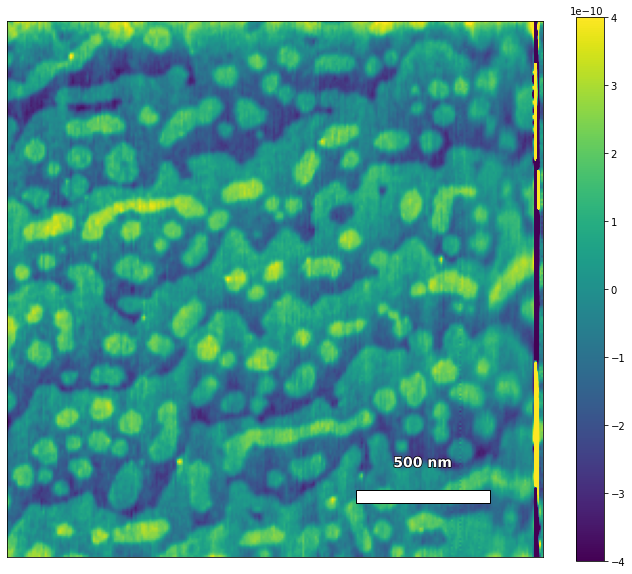

In [85]:
img = np.loadtxt('afm/RHEED_afm/test6.txt')[:256]

# m, s = np.mean(img), np.std(img)   
# colorbar_range = [m-0.28*s, m+0.28*s]
scalebar_dict = {'image_size': 2000, 'scale_size': 500, 'units': 'nm'}

imgs = visualize_afm_image(img, colorbar_range=[-4e-10, 4e-10], scalebar_dict=scalebar_dict, 
                           filename='afm/RHEED_afm/test6_py.svg')

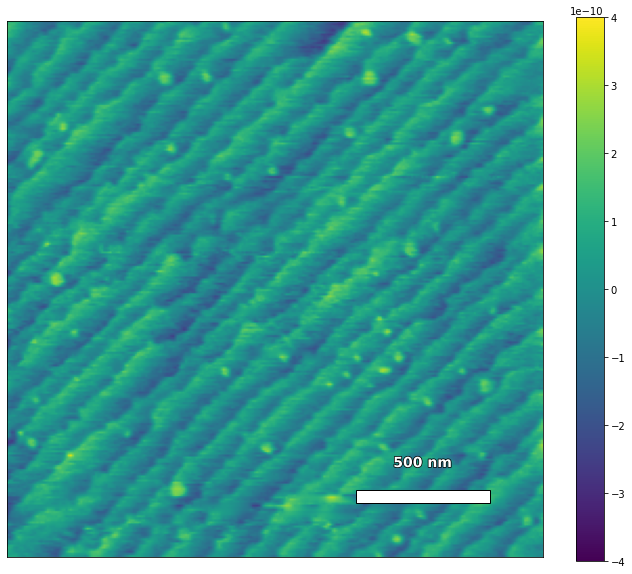

In [87]:
img = np.loadtxt('afm/RHEED_afm/test7.txt')[:256]

scalebar_dict = {'image_size': 2000, 'scale_size': 500, 'units': 'nm'}
imgs = visualize_afm_image(img, colorbar_range=[-4e-10, 4e-10], scalebar_dict=scalebar_dict, 
                           filename='afm/RHEED_afm/test7_py.svg')

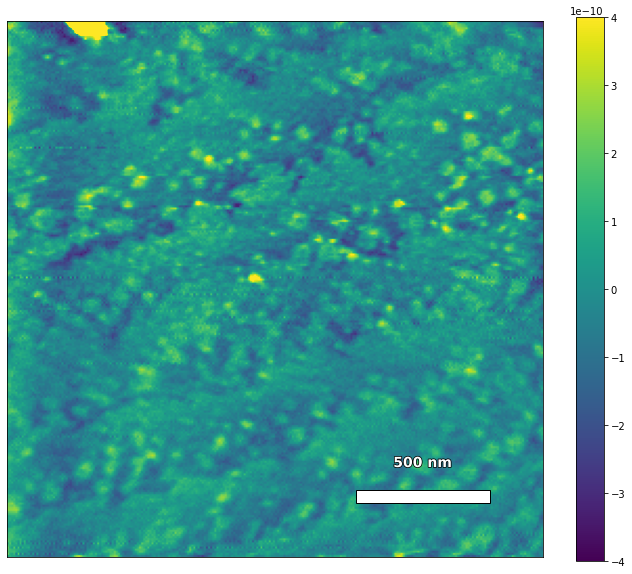

In [84]:
img = np.loadtxt('afm/RHEED_afm/test9.txt')[:256]

scalebar_dict = {'image_size': 2000, 'scale_size': 500, 'units': 'nm'}
imgs = visualize_afm_image(img, colorbar_range=[-4e-10, 4e-10], scalebar_dict=scalebar_dict, 
                           filename='afm/RHEED_afm/test9_py.svg')

In [ ]:

plt.colorbar()
plt.show()

In [47]:
img.shape

(1024, 256)

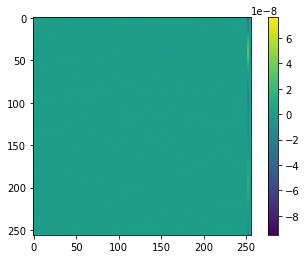

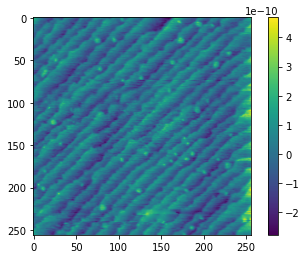

In [21]:
img = np.loadtxt('afm/pm2c_440-441/pm2c_441_0001.txt')
plt.imshow(img)
plt.colorbar()
plt.show()

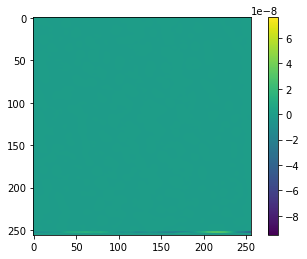

In [26]:
img = np.loadtxt('afm/pm2c_440-441/test.txt')
plt.imshow(img)
plt.colorbar()
plt.show()

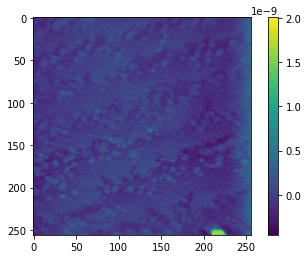

In [27]:
img = np.loadtxt('afm/PM2C_443,446/pm2c_4460002.txt')
plt.imshow(img)
plt.colorbar()
plt.show()

TypeError: Image data of dtype <U748303 cannot be converted to float

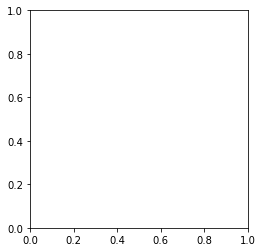

In [5]:
with open('afm/pm2c_440-441/pm2c_440-0001-1.txt', 'r') as f:
    img = f.read()
plt.imshow(img)

In [7]:
type(img)

str